## VPRTempoQuant - Basic Demo for a quantized version of VPRTempo

### By Adam D Hines (https://research.qut.edu.au/qcr/people/adam-hines/)

VPRTempo is based on the following paper, if you use or find this code helpful for your research please consider citing the source:
    
[Adam D Hines, Peter G Stratton, Michael Milford, & Tobias Fischer. "VPRTempo: A Fast Temporally Encoded Spiking Neural Network for Visual Place Recognition. arXiv September 2023](https://arxiv.org/abs/2309.10225)

### Introduction

This is a basic, extremely simplified version of VPRTempo that highlights how images are transformed, spikes and weights are used, and the readout for performance using a model trained using Quantized Aware Training (QAT). We will view the system through the lens of integer based weights and spikes to see how a quantized version of VPRTempo operates under the hood.

*Note: In this example, we will lose some amount of precision because we are only using integers for all calculations. In the deployed version, PyTorch quantizes and dequantizes spikes and weights so that some calculations are performed in the floating point domain. As such, this tutorial should be taken purely for conceptual understanding of a quantized version of VPRTempo and not for implementation purposes.*

Scales in this example are used for bit-shifting spikes, rather than the traditional multiplication or division that scaling performs on spikes for quantization.

Before starting, make sure the following packages are installed and imported:

In [1]:
# Imprt opencv-python, NumPy, and matplotlib.pyplot
try:
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt
except:
    # ! pip install numpy, opencv-python, matplotlib # pip install if modules not present
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt

### Image processing

As in the previous tutorial, we will load in a 360x640 image and show the patch-normalized version.  

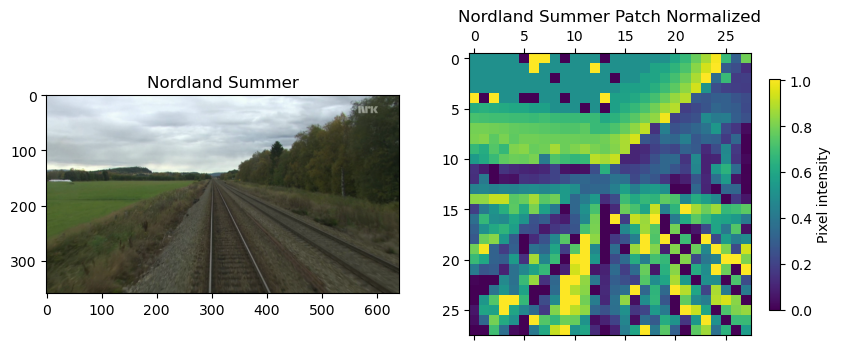

The maximum integer pixel value is 1.0075187969924813


In [2]:
# Load the input image
raw_img = cv2.imread('./mats/1_basicdemoquant/summer.png')
rgb_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB) # Convert to RGB

# Load the patch normalized image
patch_img = np.load('./mats/1_basicdemoquant/summer_patchnorm.npy', allow_pickle=True)/133

# Create a figure to hold the subplots
plt.figure(figsize=(10, 4))

# Plot the first image
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.imshow(rgb_img)
plt.title('Nordland Summer')

# Plot the second image
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.matshow(patch_img, fignum=False)
plt.title('Nordland Summer Patch Normalized')
plt.colorbar(shrink=0.75, label="Pixel intensity")

# Show the plot
plt.show()
max_int = np.max(patch_img)
print(f"The maximum integer pixel value is {max_int}")

The patch normalized image here are floating point values in the range [0, 1]. For the base VPRTempo system, this is fine because the entire system works using floating points. However, in our quantized model we will be using integers. To demonstrate the conversion from floating point to integer, we'll manually quantize our input spikes by dividing using the `scale_factor` determined from the QAT.

Let's load in some model scale factors, we'll use some of these later for the weight calculations.

In [3]:
# Load the scale factors for spikes
scale_factors = np.load('./mats/1_basicdemoquant/spikeadd_scales.npy',allow_pickle=True)
spike_scale = scale_factors[0,0]
spike_zp = scale_factors[0,1]
print(f"The scale factor for the input spikes is {spike_scale} and the zero point is {spike_zp}.")

The scale factor for the input spikes is 128 and the zero point is 0.


Now that we have our scale and zero point for the spikes, let's convert the input image into integer space.

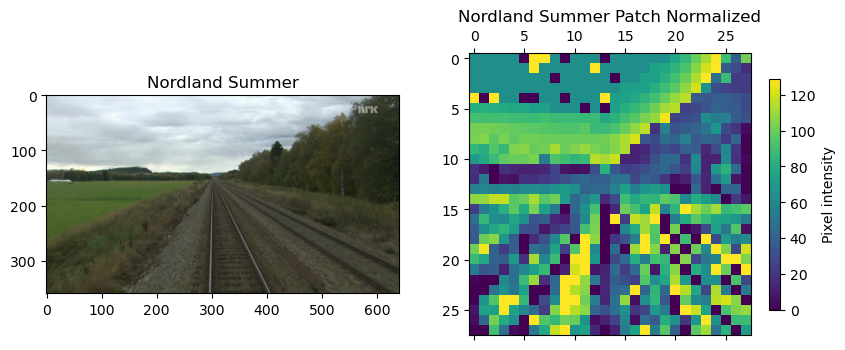

The maximum integer pixel value is 129 and the spike type is int32


In [4]:
# Scale the input image into integer space
int_img = np.round(patch_img * spike_scale).astype(np.int32)

# Create a figure to hold the subplots
plt.figure(figsize=(10, 4))

# Plot the first image
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.imshow(rgb_img)
plt.title('Nordland Summer')

# Plot the second image
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.matshow(int_img, fignum=False)
plt.title('Nordland Summer Patch Normalized')
plt.colorbar(shrink=0.75, label="Pixel intensity")

# Show the plot
plt.show()
max_int = np.max(int_img)
print(f"The maximum integer pixel value is {max_int} and the spike type is {int_img.dtype}")

Like in the previous tutorial, we will convert this to a 1D-array to pass through the layers.

In [5]:
# Convert 2D image to a 1D-array
patch_1d = np.reshape(int_img, (784,))

### Load the pre-trained network weights

Our network consists of the same architecture as in the previous tutorial. The excitatory and inhibitory weights have been converted to the integer representations from the QAT and will be applied directly to the quantized input spikes.

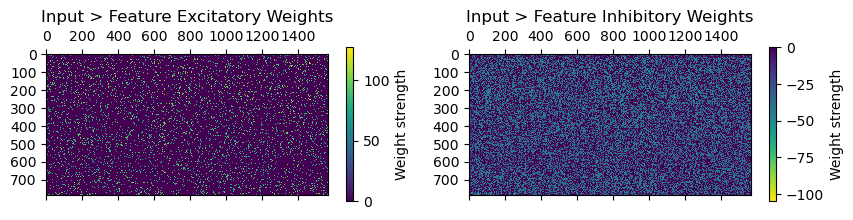

Excitatory weights scale is 13, zero point -5, and integer type is int8
Inhibitory weights is 14, zero point 184, and integer type is int8


In [6]:
# Load the input to feature excitatory and inhibitory network weights
weights_scales = np.load('./mats/1_basicdemoquant/featurelayer_scalesweights.npy',allow_pickle=True)
if_exc = weights_scales[0] # Excitatory weights
if_inh = weights_scales[1] # Inhibitory weights
if_exc_scaleszp = weights_scales[2] # Excitatory scale and zero point
if_inh_scaleszp = weights_scales[3] # Inhibitory scale and zero point

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5)) # Adjust the figure size as needed

# Plot the excitatory weights
exc_plot = axes[0].matshow(if_exc.T)
axes[0].set_title('Input > Feature Excitatory Weights')
fig.colorbar(exc_plot, ax=axes[0], shrink=0.4, label="Weight strength")

# Plot the inhibitory weights
inh_plot = axes[1].matshow(if_inh.T, cmap='viridis_r')
axes[1].set_title('Input > Feature Inhibitory Weights')
fig.colorbar(inh_plot, ax=axes[1], shrink=0.4, label="Weight strength")

# Display the plots
plt.show()

# Print dtype
print(f"Excitatory weights scale is {if_exc_scaleszp[0]}, zero point {if_exc_scaleszp[1]}, and integer type is {if_exc.dtype}")
print(f"Inhibitory weights is {if_inh_scaleszp[0]}, zero point {if_inh_scaleszp[1]}, and integer type is {if_inh.dtype}")

### Propagate network spikes

Now we'll propagate the input spikes across the feature to get the output, like in the previous tutorial. Let's start with the excitatory weights though first, since we will need to use different scaling of the output based on the zero point.

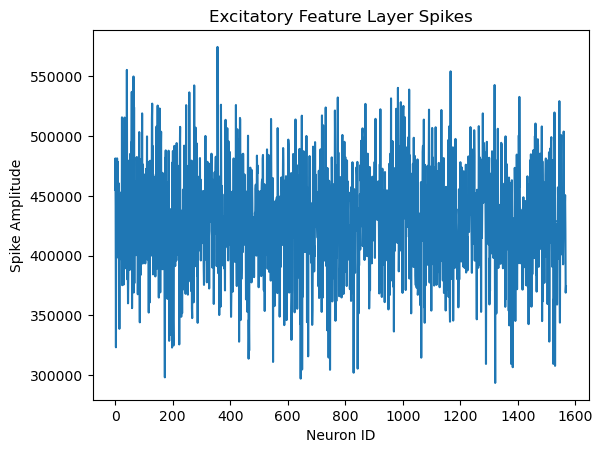

In [7]:
# Calculate feature spikes for the positive weight calculation
exc_feature_spikes = (np.matmul(if_exc,patch_1d))

# Now create the line plot
plt.plot(np.arange(len(exc_feature_spikes)), exc_feature_spikes)

# Add title and labels if you wish
plt.title('Excitatory Feature Layer Spikes')
plt.xlabel('Neuron ID')
plt.ylabel('Spike Amplitude')
# Show the plot
plt.show()

We now need to scale the feature layer spikes back in order to propagate to the output layer. Here, we will bit-shift the spikes based on the excitatory scale factor and add the zero point.

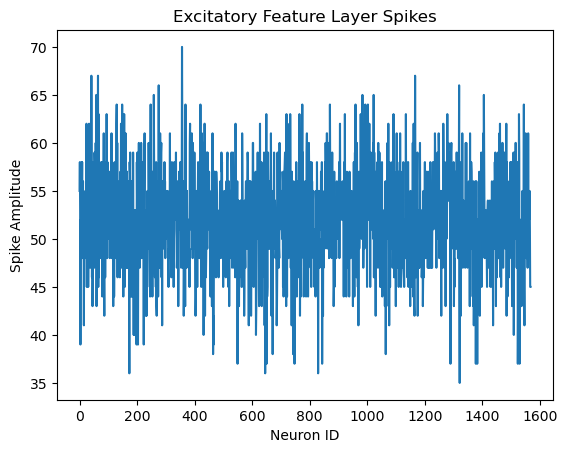

In [18]:
# Bit shift the feature layer spikes based on the excitatory scale factor and add the zero point
scaled_exc_feature_spikes = (exc_feature_spikes >> if_exc_scaleszp[0])

# Plot out the scaled feature layer spikes
plt.plot(np.arange(len(scaled_exc_feature_spikes)), scaled_exc_feature_spikes)

# Add title and labels if you wish
plt.title('Excitatory Feature Layer Spikes')
plt.xlabel('Neuron ID')
plt.ylabel('Spike Amplitude')
# Show the plot
plt.show()

Now let's do the same thing for our inhibitory weights.

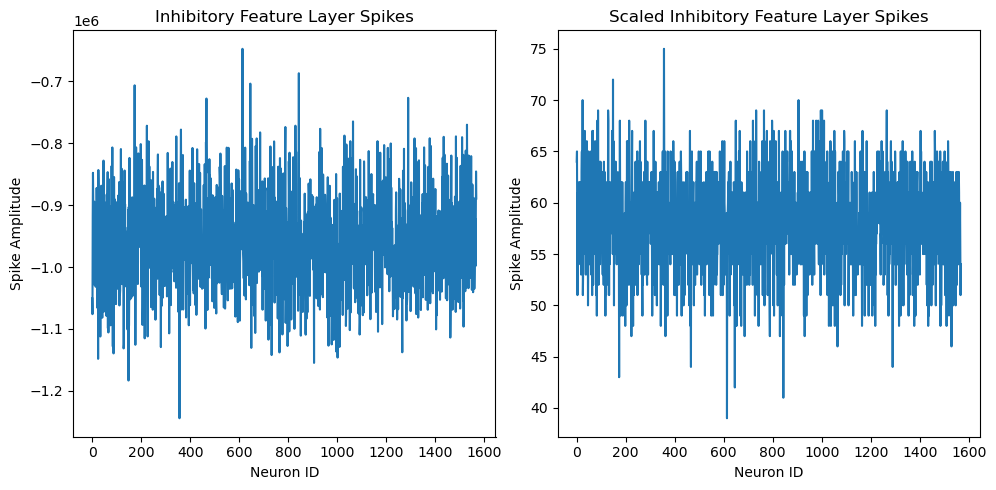

In [19]:
# Calculate feature spikes for the negative weight calculation
inh_feature_spikes = (np.matmul(if_inh, patch_1d))

# Bit shift the feature layer spikes based on the scale factor and add the zero point
scaled_inh_feature_spikes = np.abs(inh_feature_spikes + if_inh_scaleszp[1]) >> if_inh_scaleszp[0]

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 'figsize' can be adjusted as needed

# First subplot
axs[0].plot(np.arange(len(inh_feature_spikes)), inh_feature_spikes)
axs[0].set_title('Inhibitory Feature Layer Spikes')
axs[0].set_xlabel('Neuron ID')
axs[0].set_ylabel('Spike Amplitude')

# Second subplot
axs[1].plot(np.arange(len(scaled_inh_feature_spikes)), scaled_inh_feature_spikes)
axs[1].set_title('Scaled Inhibitory Feature Layer Spikes')
axs[1].set_xlabel('Neuron ID')
axs[1].set_ylabel('Spike Amplitude')

# Adjust the layout
plt.tight_layout()
# Show the plot
plt.show()


One thing you may notice is that although we used negative weights, we output positive spikes from in this operation. That is because of the `zeropoint_inh` of 127, which we add to the final spike calculation.

Now that we separately calculated our positive and negative feature layer spikes, we need to add them together to get the final feature spikes. However, we'll note that because the scales and zero points for the two operations are different they will require to undergo additional transformation to match the scales. In the VPRTempoQuant model, we derive this addition scale and zero point from the `nn.quantized.FloatFunctional.add` function which learns these values during QAT. 

In [ ]:
# Get addition scale and zero point
add_scale = scale_factors[1,0]
add_zeropoint = scale_factors[1,1]

# Bit shift to the addition scale
exc_add = (exc_feature_spikes + add_zeropoint)  >> add_scale
inh_add = np.abs(inh_feature_spikes + add_zeropoint) >> add_scale

# Combine the spikes and subtract the add zero point
combined = exc_add + inh_add

# Clip spikes
#combined = np.clip(combined,0,255)

# Plot the combined spikes
plt.plot(np.arange(len(combined)), inh_add)

# Add title and labels if you wish
plt.title('Combined Feature Layer Spikes')
plt.xlabel('Neuron ID')
plt.ylabel('Spike Amplitude')
# Show the plot
plt.show()

Now we will apply the same process for the output layer to get the output spikes.

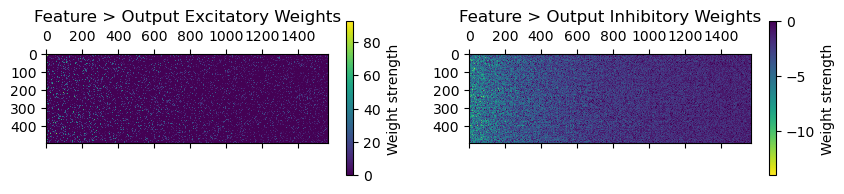

Excitatory weights integer type is int8
Inhibitory weights integer type is int8


In [20]:
# Load the input to feature excitatory and inhibitory network weights
weights_scales = np.load('./mats/1_basicdemoquant/outputlayer_scalesweights.npy',allow_pickle=True)
fo_exc = weights_scales[0] # Excitatory weights
fo_inh = weights_scales[1] # Inhibitory weights

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5)) # Adjust the figure size as needed

# Plot the excitatory weights
exc_plot = axes[0].matshow(fo_exc)
axes[0].set_title('Feature > Output Excitatory Weights')
fig.colorbar(exc_plot, ax=axes[0], shrink=0.4, label="Weight strength")

# Plot the inhibitory weights
inh_plot = axes[1].matshow(fo_inh, cmap='viridis_r')
axes[1].set_title('Feature > Output Inhibitory Weights')
fig.colorbar(inh_plot, ax=axes[1], shrink=0.4, label="Weight strength")

# Display the plots
plt.show()

# Print dtype
print(f"Excitatory weights integer type is {if_exc.dtype}")
print(f"Inhibitory weights integer type is {if_inh.dtype}")

Instead of scaling the output spikes based on their respective excitatory and inhibitory scales, we can just go straight for the addition scaling.

In [ ]:
# Calculate the excitatory and inhibitory spikes and scale them
exc_output_spikes = np.matmul(fo_exc,combined)
scaled_exc_output_spikes = ((exc_output_spikes - add_zeropoint) >> add_scale)

inh_output_spikes = np.matmul(fo_inh,combined)
scaled_inh_output_spikes = (np.abs(inh_output_spikes - add_zeropoint) >> add_scale)

# Combine the excitiatory and inhibitory feature spikes
output_spikes = scaled_exc_output_spikes + scaled_inh_output_spikes - add_zeropoint
#output_spikes = np.clip(output_spikes,0,max_int)

# Plot the combined spikes
plt.plot(np.arange(len(output_spikes)), output_spikes)

# Add title and labels if you wish
plt.title('Combined Output Layer Spikes')
plt.xlabel('Neuron ID')
plt.ylabel('Spike Amplitude')
# Show the plot
plt.show()

In [ ]:
combined_approx = combined

In [ ]:
# Calculate the excitatory and inhibitory spikes and scale them
exc_output_spikes_approx = np.round(np.matmul(fo_exc,combined_approx))
scaled_exc_output_spikes_approx = approximate_division(exc_output_spikes_approx, fo_scales[0]) 

inh_output_spikes_approx = (np.matmul(fo_inh,combined_approx.astype(np.int32)))
# scaled_inh_output_spikes_approx = (inh_output_spikes_approx - zeropoint_inh) // fo_scales[1]
scaled_inh_output_spikes_approx = approximate_division(inh_output_spikes_approx - zeropoint_inh, fo_scales[1])

# Combine the excitiatory and inhibitory feature spikes
# exc_rescaled_approx = (scaled_exc_output_spikes_approx/fo_scales[2]) * combined_scale
exc_rescaled_approx = approximate_division(scaled_exc_output_spikes_approx * combined_scale, fo_scales[2])
# inh_rescaled_approx = ((scaled_inh_output_spikes_approx - zeropoint_inh)/fo_scales[3]) * combined_scale
inh_rescaled_approx = approximate_division((scaled_inh_output_spikes_approx - zeropoint_inh) * combined_scale, fo_scales[3])

output_spikes_approx = (exc_rescaled_approx.astype(np.int32) + inh_rescaled_approx.astype(np.int32)) + combined_zeropoint
output_spikes_approx = np.clip(output_spikes_approx,0,2**24)

# Plot the combined spikes
plt.plot(np.arange(len(output_spikes_approx)), output_spikes_approx)

# Add title and labels if you wish
plt.title('Combined Output Layer Spikes (approx)')
plt.xlabel('Neuron ID')
plt.ylabel('Spike Amplitude')
# Show the plot
plt.show()

And now, as in the previous tutorial, we can clearly see that Neuron ID has the highest output spike amplitude corresponding to our first learned location.

Let's quickly prove it.

In [ ]:
# Output the argmax from the output spikes
prediction = np.argmax(output_spikes)
print(f"Neuron ID with the highest output is {prediction}")

### Conclusions

We have gone through a very basic demo of how VPRTempoQuant works and the operations involved for quantizing floating points spikes and weights into the integer domain. Although this is isn't exactly how PyTorch performs these tasks (a lot of them are done in the FP space, especially with regards to rescaling for addition) - it should give you a good idea as to how we can perform these kinds of operations in whole integers. This is particularly useful for implementation on hardware such as neuromorphic processors.

If you would like to go more in-depth with training and inferencing, checkout some of the [other tutorials](https://github.com/AdamDHines/VPRTempo-quant/tree/main/tutorials) which show you how to train your own model and goes through the more sophisticated implementation of VPRTempo.